# Imports

In [7]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
# import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]
import ray

# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# .describe(include='all', datetime_is_numeric=True)
# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'
# pd.set_option('precision', 2)
# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from data_model import arrow_dataset, fsspec_storage, db
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, stacked, daily_stats
from workflows import sampler_task, sampler_flow
from utilities import date_fu, globals_unsafe as g

from data_layer import storage_adaptor

config = {
    'meta': {
        'symbol': 'GORO',
        'start_date': '2020-12-01',
        'end_date': '2020-12-04',
        'config_id': 'renko_v1',
    },
    'filter': {
        'mad_value_winlen': 22,
        'mad_deviation_winlen': 1111,
        'mad_k': 17,
        'jma_winlen': 7,
        'jma_power': 2,
    },
    'sampler': {
        'renko_return': 'price_jma_return',
        'renko_size': 0.1,  # for simple runs
        'renko_reveral_multiple': 2,
        'renko_range_frac': 22,
        'renko_range_min_pct_value': 0.03,  # % of symbol value enforced as min renko size
        'max_duration_td': dt.timedelta(minutes=33),
        'min_duration_td': dt.timedelta(seconds=33),
        'min_tick_count': 33,
        'add_label': True,
        'reward_ratios': list(np.arange(2, 11, 0.5)),
    }
}

In [3]:
db = storage_adaptor.StorageAdaptor()

db.list_symbol_storage_used('market', '/data/daily')

db.list_symbol_dates(config['meta']['symbol'], '/tick_samples/renko_v1/bar_date')

# Sample tick dates

In [28]:
bd = sampler_task.sample_date(config, date='2020-01-02')

/Users/bobcolner/QuantClarity/sopadilo/workflows/sampler_task.py:22: UserWarning: Discarding nonzero nanoseconds in conversion
  tick_filter.update(


In [3]:
ray.init(dashboard_port=1111, ignore_reinit_error=True)

2021-05-27 22:33:14,499	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:1111


{'node_ip_address': '192.168.1.66',
 'raylet_ip_address': '192.168.1.66',
 'redis_address': '192.168.1.66:6379',
 'object_store_address': '/tmp/ray/session_2021-05-27_22-33-12_315429_25504/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-27_22-33-12_315429_25504/sockets/raylet',
 'webui_url': '127.0.0.1:1111',
 'session_dir': '/tmp/ray/session_2021-05-27_22-33-12_315429_25504',
 'metrics_export_port': 53211,
 'node_id': 'f79e36cb6be11de32c8ae41433325f042540d587a32645255177b995'}

In [5]:
ray.shutdown()

In [4]:
bds = sampler_flow.tick_sampler_flow(config, ray_on=True)


(pid=25525) /Users/bobcolner/QuantClarity/sopadilo/workflows/sampler_task.py:22: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=25525)   tick_filter.update(
(pid=25526) /Users/bobcolner/QuantClarity/sopadilo/workflows/sampler_task.py:22: UserWarning: Discarding nonzero nanoseconds in conversion
(pid=25526)   tick_filter.update(


<AxesSubplot:>

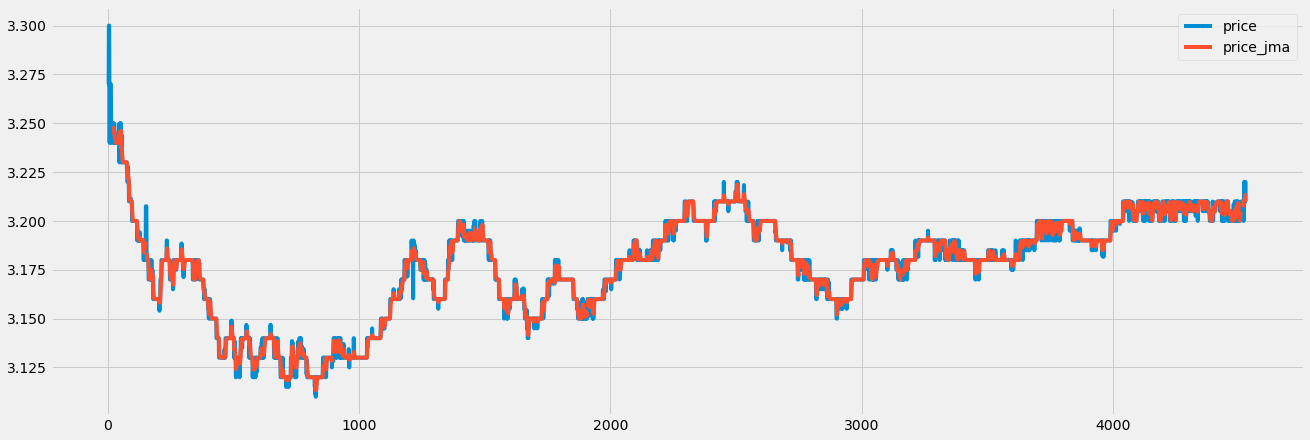

In [8]:
bds[0]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:>

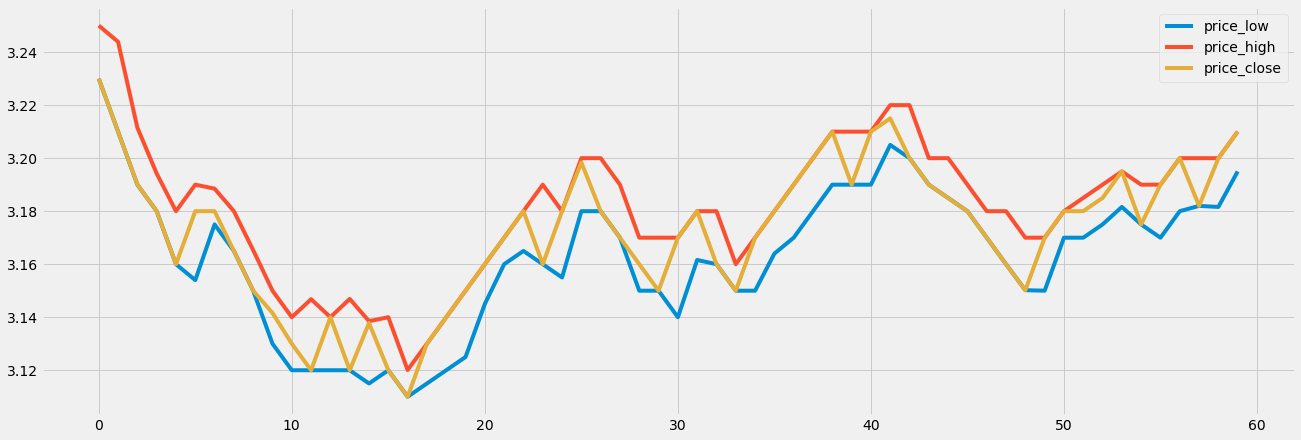

In [9]:
bds[0]['bars_df'][['price_low', 'price_high', 'price_close']].plot()

In [ ]:
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bds, fill_col='price_vwap')

stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked_df[['price_high','price_low','price_vwap']].plot()

In [ ]:
# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)

stats_df

stats_df.describe()